<a href="https://colab.research.google.com/github/likhitha-dhanaraju/smart-assist-chatbot/blob/model_development/Fine_tune_BLIP_on_an_image_captioning_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions.
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [1]:
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-lr0zpu2p
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-lr0zpu2p
  Resolved https://github.com/huggingface/transformers.git to commit 76a33a10923ccc1074917f6b6a1e719e626b7dc9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.40.0.dev0-py3-none-any.whl size=8802691 sha256=76ec3a1e78a7299c6a5f499c21eb852331e1f6779645dbd5ebdb5d21b82c9611
  Stored in directory: /tmp/pip-ephem-wheel-cache-8um9ffv6/wheels/cf/59/82/6492402e887a68975030bf8c06532260abc16abb7ccd8127cc
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [2]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00


## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from datasets import load_dataset, load_from_disk

dataset = load_from_disk('/content/drive/MyDrive/03 EDHEC/val_dataset')

Let's retrieve the caption of the first example:

In [5]:
dataset[0]["text"]

'type to learn 3softwareeducation reference home position friendly reminder on proper keyboarding positioning warmup loosen up fingers in home row review checkpoint quick review of previously learned lessons learn new keys animated 3d hands introduce new keystrokes on color coded keyboard exercise direct keyboarding instruction with automatic reviewi and plenty of practice'

And the corresponding image

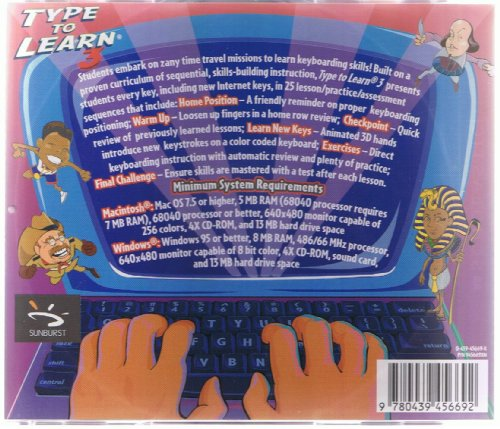

In [6]:
dataset[0]["image"]

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [7]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [8]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [9]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
    print("Epoch:", epoch)
    try:
        for idx, batch in enumerate(train_dataloader):

            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)

            loss = outputs.loss

            print("Loss:", loss.item())

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
    except:
        continue


Epoch: 0
Loss: 7.24033784866333
Loss: 7.3874688148498535
Loss: 7.014176368713379
Loss: 6.678022861480713
Loss: 6.852202892303467
Loss: 7.018444061279297
Loss: 7.064487934112549
Loss: 6.810429096221924
Loss: 6.511491775512695
Loss: 6.5741448402404785
Loss: 6.380682468414307
Loss: 6.159799575805664
Loss: 6.2621750831604
Loss: 6.056636333465576
Loss: 6.04926872253418
Loss: 6.171624660491943
Loss: 5.964574337005615
Loss: 5.792596340179443
Loss: 5.653109550476074
Loss: 6.354722023010254
Loss: 5.704995155334473
Loss: 5.942245960235596
Loss: 5.356602668762207
Loss: 5.228333950042725
Loss: 5.3227219581604
Loss: 5.336491107940674
Loss: 5.434199333190918
Loss: 5.100200653076172
Epoch: 1
Loss: 5.493715763092041
Loss: 4.738524436950684
Loss: 4.522064685821533
Loss: 4.466487407684326
Loss: 4.976943016052246
Loss: 4.549402236938477
Loss: 4.480886459350586
Loss: 4.554653644561768
Loss: 4.238772869110107
Loss: 4.537112236022949
Loss: 5.027667999267578
Loss: 4.548731803894043
Loss: 3.994394540786743
Lo

In [ ]:
# Save the model
import os

save_path = '/content/drive/MyDrive/03 EDHEC/saved_models/'

if not os.path.exists(save_path):
    os.mkdir(save_path)

model.save_pretrained(save_path)

In [ ]:
# Save the model
import os

save_path = '/content/drive/MyDrive/03 EDHEC/saved_models_version 2/'

if not os.path.exists(save_path):
    os.mkdir(save_path)

model.save_pretrained(save_path, from_pt=True)

## Inference

Let's check the results on our train dataset

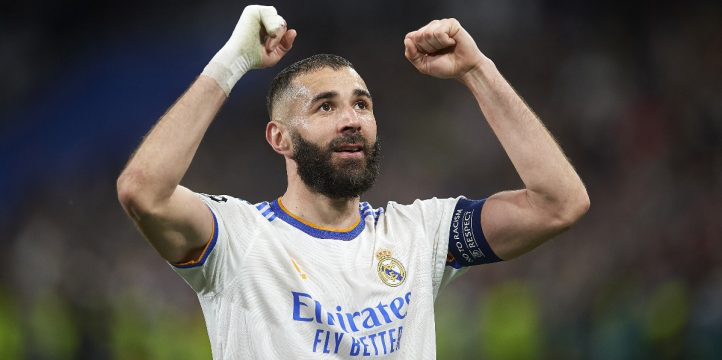

In [ ]:
# load image
example = dataset[0]
image = example["image"]
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

benzema after real mardid's win against psg


## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later.
Meanwhile you can play with the model that we have fine-tuned!

In [ ]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(device)
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

Downloading:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/990M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/431 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/488 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Let's check the results on our train dataset!

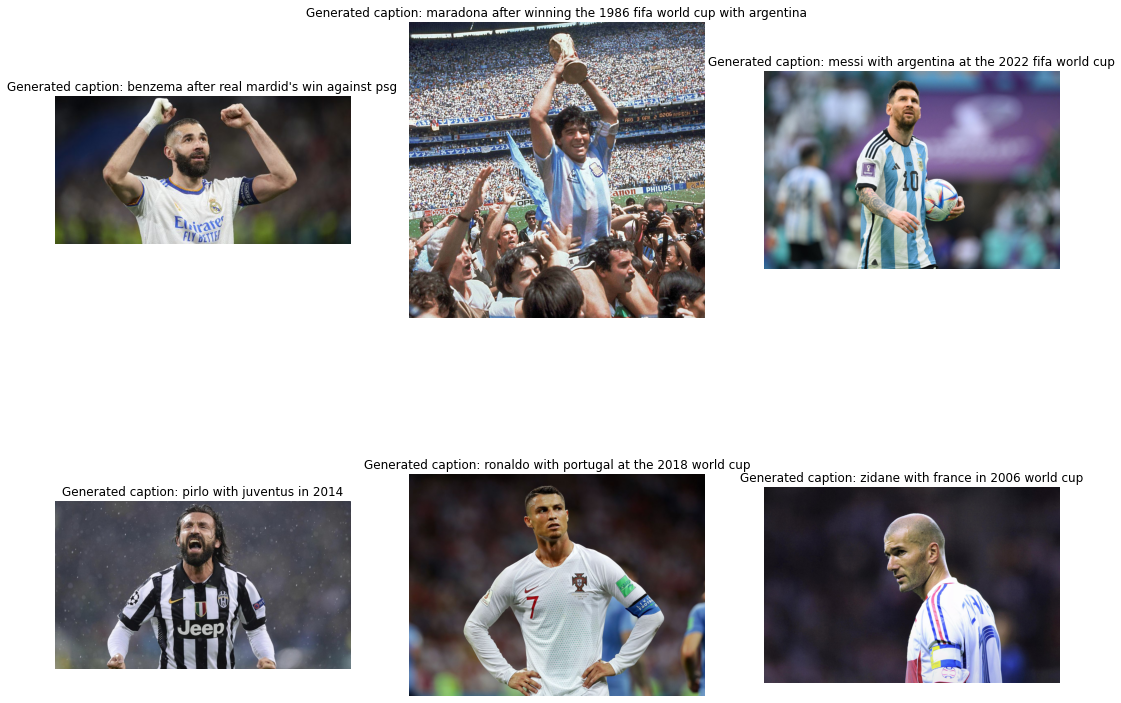

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")